In [ ]:
import main
import warnings
import itertools
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

from tqdm import tqdm

from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from prophet import Prophet



Importing plotly failed. Interactive plots will not work.


--------------------------------------------------------------------------------------

------------------------------------------------------------------------------

<h1> PARTE 2 <h1>

In [ ]:
data2 = pd.read_excel('https://www.ime.usp.br/~pam/LAVRAS.XLS')
data2['Mes/ano'] = main.time_data2()
data2.set_index('Mes/ano', inplace = True)

In [ ]:
data2

,Precipitação
Mes/ano,
1966-01-01,515.0
1966-02-01,237.1
1966-03-01,224.2
1966-04-01,24.4
1966-05-01,11.6
...,...
1997-08-01,1.2
1997-09-01,38.8
1997-10-01,164.1


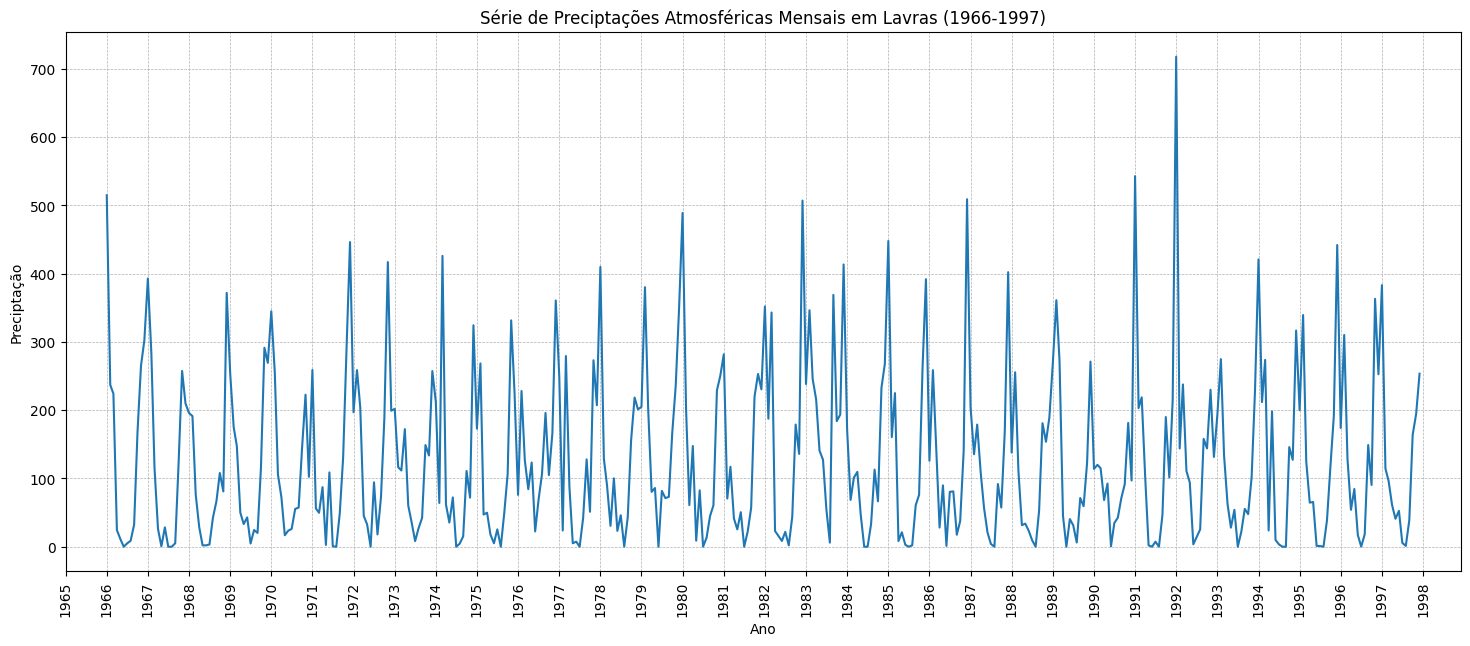

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(data2['Precipitação'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xticks(rotation=90)
plt.xlim(pd.Timestamp('1965-01-01'), pd.Timestamp('1998-12-01'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')
plt.show()


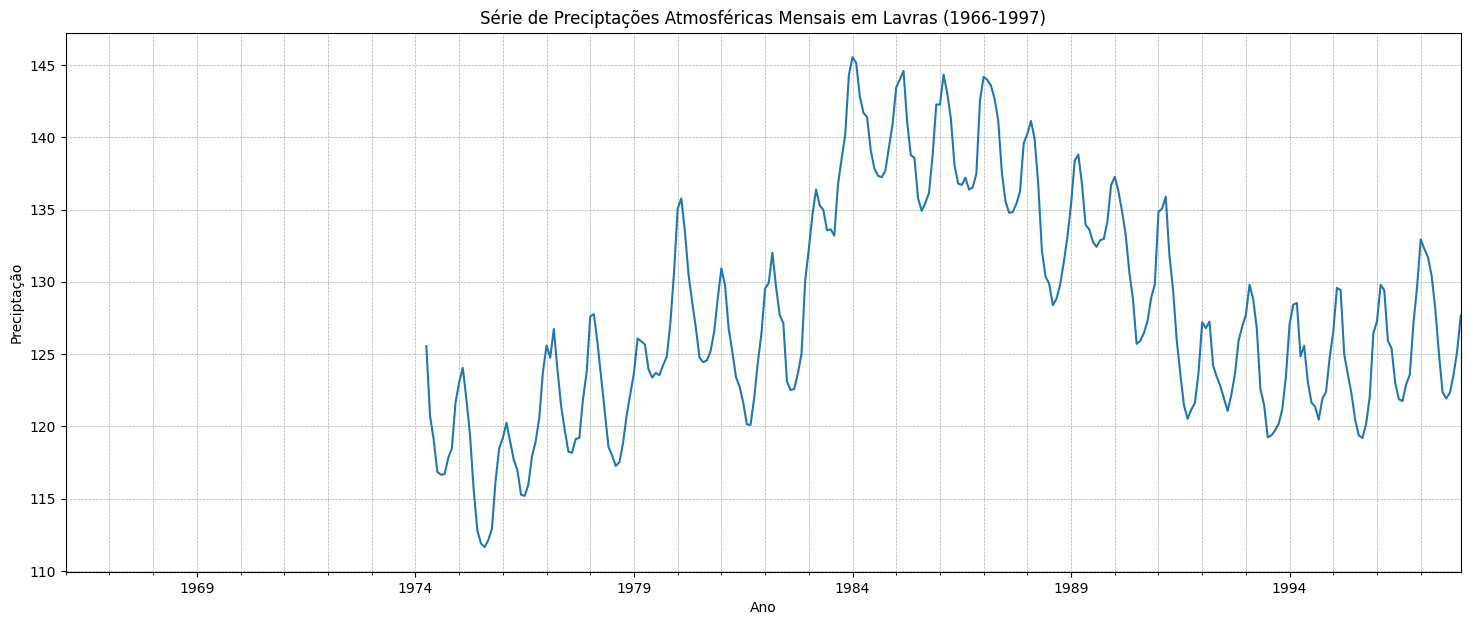

In [ ]:
data2['Precipitação'].rolling(100).mean().plot(figsize=(18, 7))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.show()

- Após realizar uma análise de tendência, observou-se que a série temporal apresenta uma tendência de crescimento leve.

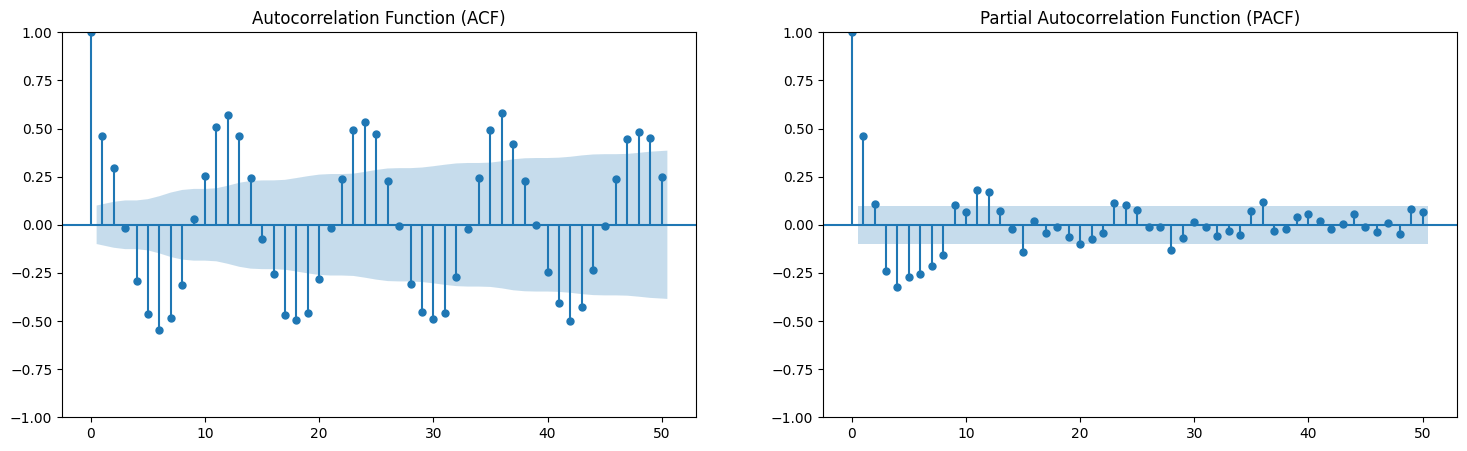

In [ ]:
main.data2_acf_pacf(data2['Precipitação'])

In [ ]:
result = adfuller(data2['Precipitação'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -4.716706
p-value: 0.000078
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


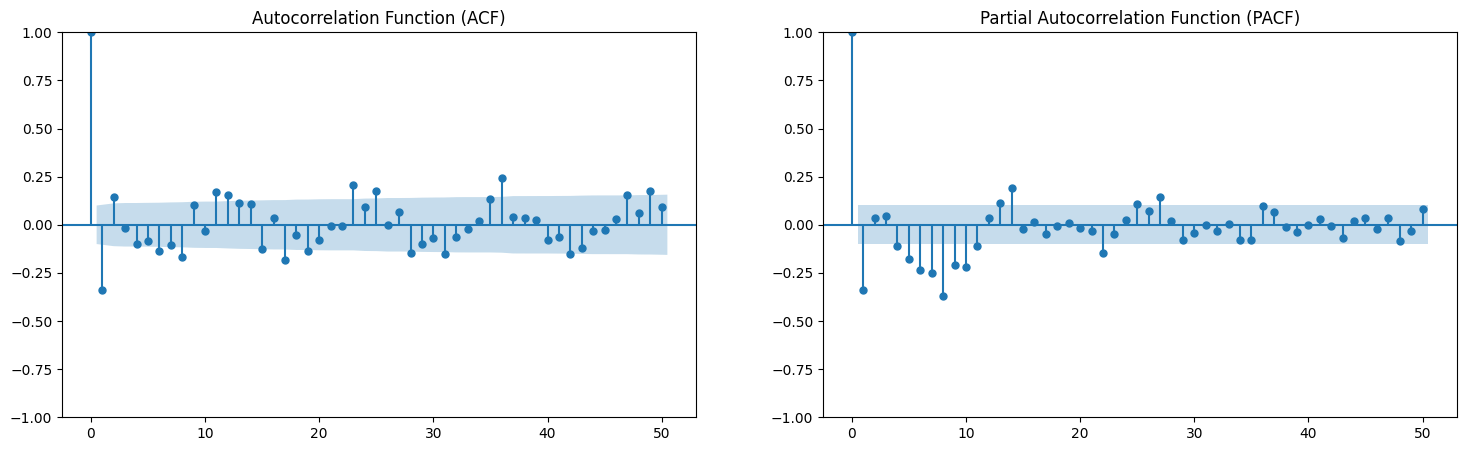

In [ ]:
df = data2.copy()
df['Precipitação_1']=df['Precipitação'].diff()
df.dropna(axis=0, inplace = True)
main.data2_acf_pacf(df['Precipitação_1'])

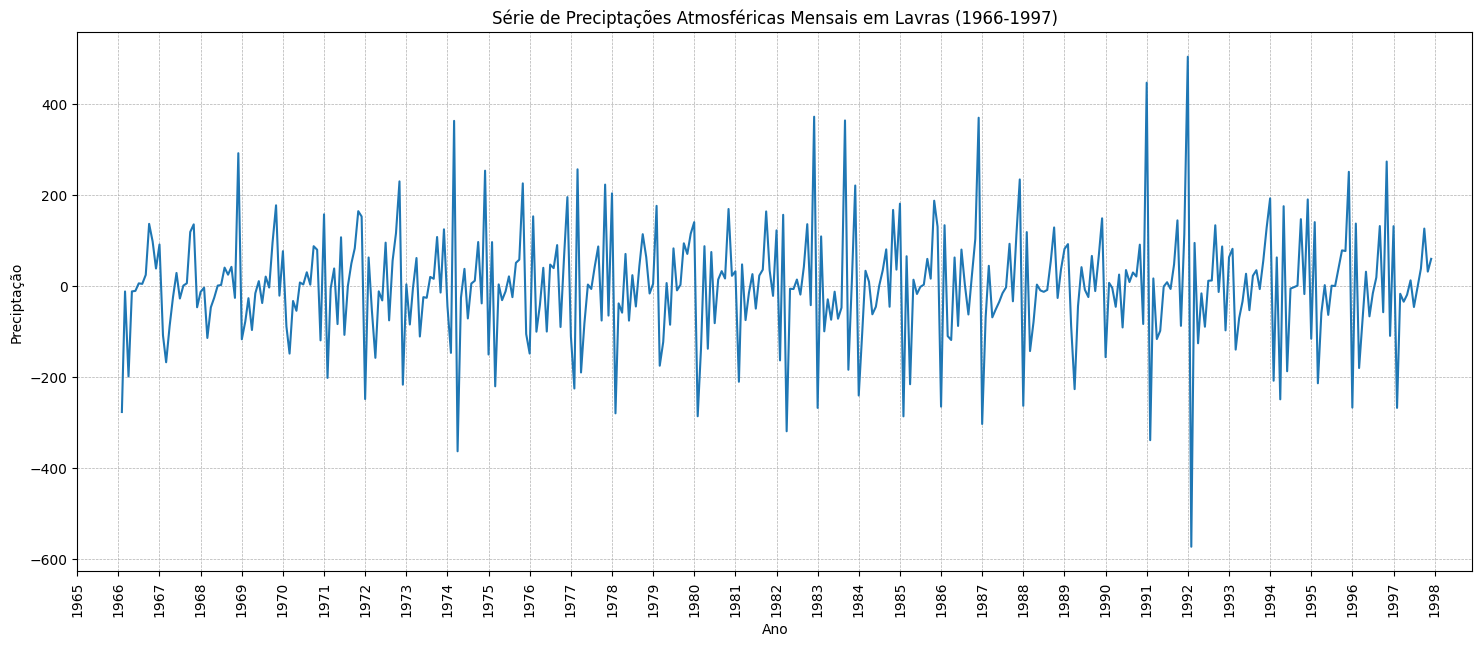

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(df['Precipitação_1'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xticks(rotation=90)
plt.xlim(pd.Timestamp('1965-01-01'), pd.Timestamp('1998-12-01'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.show()

In [ ]:
result = adfuller(df['Precipitação_1'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -9.015103
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


- Ao examinar os dados originais, identificou-se uma leve tendência crescente na série temporal. A análise visual do ACF  e PACF sugeriu uma possível não estacionariedade na base. No entanto, ao aplicar o teste de Dickey-Fuller, os resultados divergiram, indicando estacionariedade. Devido à discrepância entre os resultados, optou-se por realizar a estacionarização por meio da diferenciação. Após a aplicação de diferenciação de ordem 1, todos os quatro testes confirmaram a estacionaridade da série temporal.

- SARIMA

In [ ]:
threshold = int(0.8*len(data2))
train_set = data2[:threshold]
test_set = data2[threshold:]

In [ ]:
for a1, a2, a3 in itertools.product(range(1, 5), range(1, 5), range(1, 5)):
    try:
        sarima = SARIMAX(train_set['Precipitação'], order=(a1, a2, a3), seasonal_order=(2,1,2,12)).fit()
        print(f'MSE: {(sarima.resid**2).mean()}, AIC: {sarima.aic}, BIC: {sarima.bic}, {a1,a2,a3}')
    except Exception as e:
        print(f'Erro para a combinação {a1, a2, a3}: {e}')

MSE: 7630.541924719399, AIC: 3433.4603632730405, BIC: 3459.245421644411, (1, 1, 1)
MSE: 7615.153397144066, AIC: 3434.8209147997204, BIC: 3464.28955293843, (1, 1, 2)
MSE: 7635.259561002936, AIC: 3437.912723802086, BIC: 3471.064941708134, (1, 1, 3)
MSE: 7566.15527985394, AIC: 3436.9191403193367, BIC: 3473.7549379927236, (1, 1, 4)
MSE: 11715.085090211342, AIC: 3534.996381219354, BIC: 3560.7575894824736, (1, 2, 1)
MSE: 9244.029464574793, AIC: 3440.4585085574636, BIC: 3469.8998894296, (1, 2, 2)
MSE: 9266.48453555818, AIC: 3442.9769827055684, BIC: 3476.098536186722, (1, 2, 3)
MSE: 9243.378720899962, AIC: 3444.4481124889508, BIC: 3481.2498385791214, (1, 2, 4)
MSE: 26399.87001344656, AIC: 3765.353127273022, BIC: 3791.0904038889, (1, 3, 1)
MSE: 15419.322360150401, AIC: 3541.992697753312, BIC: 3571.4067281714583, (1, 3, 2)
MSE: 13118.728650517462, AIC: 3453.4664085522536, BIC: 3486.5571927726683, (1, 3, 3)
MSE: 13232.906755476894, AIC: 3456.983008597089, BIC: 3493.7505466197717, (1, 3, 4)
MSE: 6

In [ ]:
sarima = SARIMAX(train_set['Precipitação'], order=(1, 1, 4), seasonal_order=(2,1,2,12)).fit()

In [ ]:
print('MSE:',(sarima.resid**2).mean())
print('AIC:',sarima.aic)
print('BIC:',sarima.bic)

MSE: 7566.418391343483
AIC: 3436.9517321851345
BIC: 3473.7875298585213


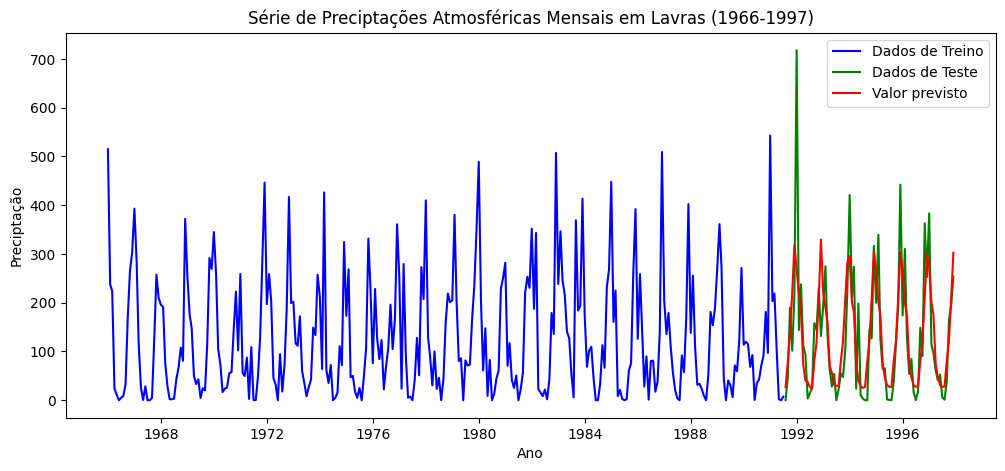

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set['Precipitação'], label='Dados de Treino',color='blue')
plt.plot(test_set['Precipitação'], label='Dados de Teste',color='green')
plt.plot(sarima.forecast(77), label='Valor previsto',color='red')
plt.legend()

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.show()

In [ ]:
print('RMSE TESTE', main.erro2(sarima,test_set))

RMSE TESTE 205.5790471927138


In [ ]:
sarima = SARIMAX(data2['Precipitação'], order=(1, 1, 4), seasonal_order=(2,1,2,12)).fit()
sarima.forecast(1)

1998-01-01    292.349226
Freq: MS, dtype: float64

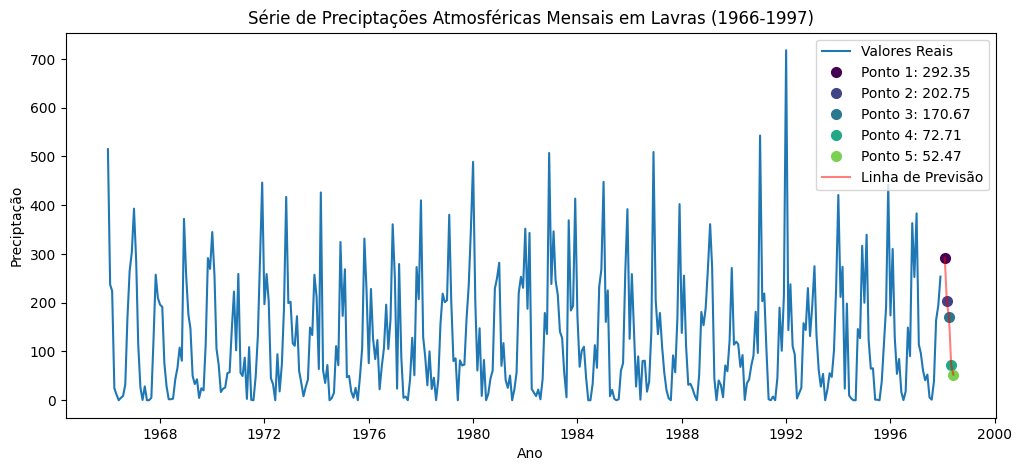

In [ ]:
forecast_index = pd.date_range(start=data2.index[-1], periods=6, freq='M')[1:]
plt.figure(figsize=(12, 5))
plt.plot(data2['Precipitação'], label='Valores Reais')
for i, (value, date) in enumerate(zip(sarima.forecast(5), forecast_index)):
    color = plt.cm.viridis(i / len(sarima.forecast(5)))
    plt.plot(date, value, 'o', color=color, markersize=7, label=f'Ponto {i + 1}: {value:.2f}')

line, = plt.plot(forecast_index, sarima.forecast(5), 'r-', color='red', alpha=0.5, label='Linha de Previsão')
plt.xlabel('Data')
plt.ylabel('Precipitação')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(line)
plt.legend(handles, labels, loc='best')

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.show()

Não será feita suavização exponencial simples pois a série não tem comportamento aleatório

<h2> Suavização Exponencial de Holt</h2>

In [ ]:
threshold = int(0.8*len(data2['Precipitação']))
train_set = data2[:threshold]
test_set = data2[threshold:]

In [ ]:
smoot_level = 0.1
smoot_trend = 0.1
menor_mse = float('inf')
melhor_sl = 0
melhor_st = 0
while True:
    print(f'smooth_trend {smoot_trend}')
    if smoot_trend >0.9:
        break
    while True:
        if smoot_level >0.95:
            break
        SEH = Holt(train_set).fit(smoothing_level=smoot_level, smoothing_trend=0.9, optimized=False)
        MSE_Treino = ((SEH.resid)**2).mean()
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_sl = smoot_level
            melhor_st = smoot_trend

        MSE_Teste = mean_squared_error(test_set,SEH.forecast(len(test_set)))
        #print(f'SMOOTHING LEVEL= {round(smoot_level,2)} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')
        smoot_level+=0.01
    smoot_trend +=0.1
    smoot_level = 0


print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SL = {round(melhor_sl,2)} MELHOR ST = {round(melhor_st,2)}')


smooth_trend 0.1
smooth_trend 0.2
smooth_trend 0.30000000000000004
smooth_trend 0.4
smooth_trend 0.5
smooth_trend 0.6
smooth_trend 0.7
smooth_trend 0.7999999999999999
smooth_trend 0.8999999999999999
smooth_trend 0.9999999999999999
MENOR MSE TREINO=17996.89 MELHOR SL = 0.55 MELHOR ST = 0.1


In [ ]:
SEH_final = Holt(train_set).fit(smoothing_level=melhor_sl, smoothing_trend=melhor_st, optimized=False)

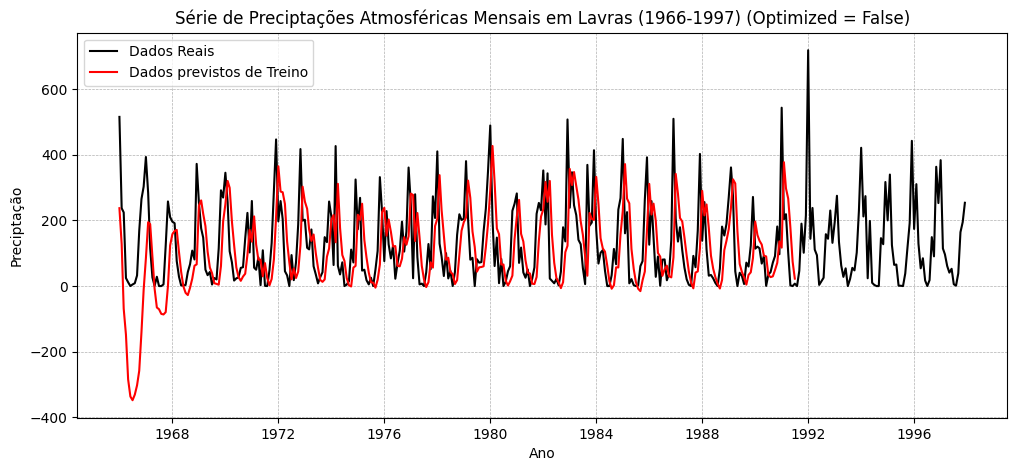

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')
plt.plot(SEH_final.fittedvalues, color='red', label='Dados previstos de Treino')
plt.legend()

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997) (Optimized = False)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

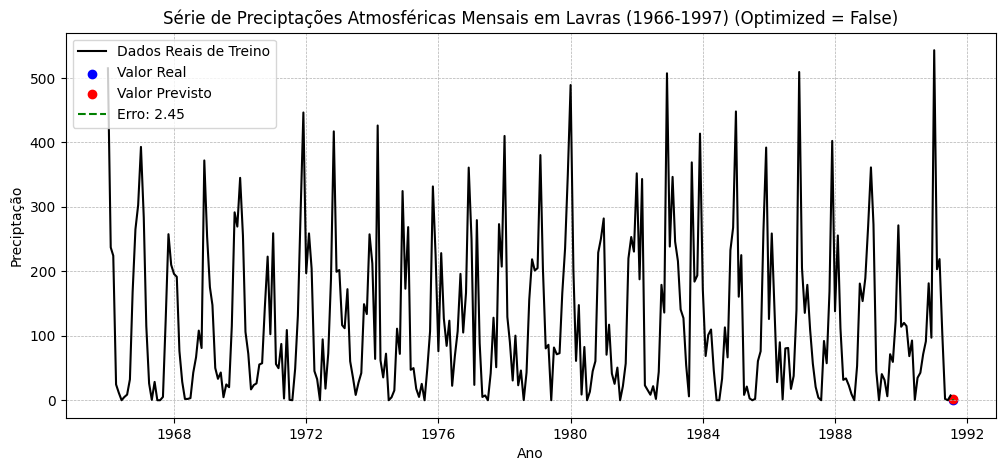

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SEH_final.forecast(1), color='red', marker='o', label='Valor Previsto')

x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SEH_final.forecast(1).values[0]]
erro = ((SEH_final.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.legend()
plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997) (Optimized = False)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SEH_final.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SEH_final.fittedvalues)**(1/2)}')

MSE TREINO: 18515.412063272
RMSE TREINO: 136.07134916385596


In [ ]:
print('RMSE', ((SEH_final.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2))

RMSE 2.447105602209543


In [ ]:
SEH_final = Holt(data2).fit(smoothing_level=melhor_sl, smoothing_trend=melhor_st, optimized=False)

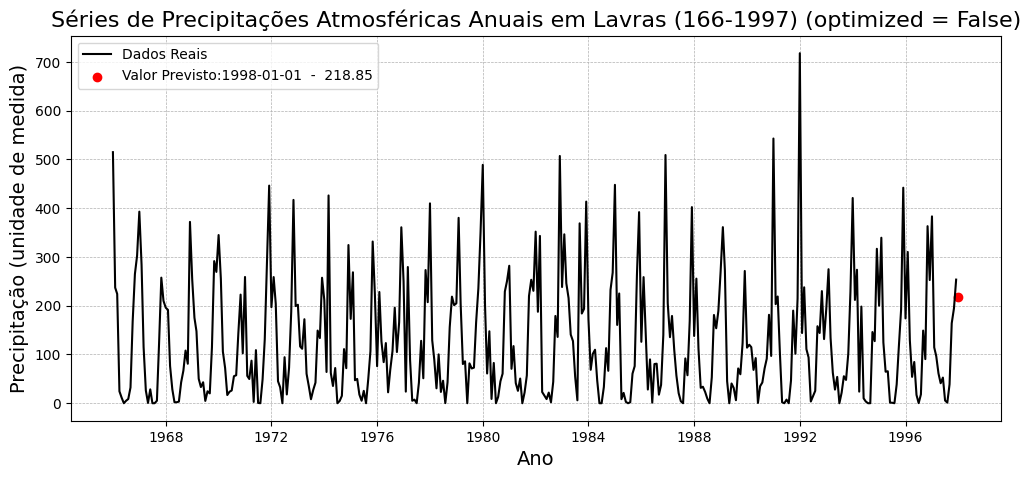

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')

plt.scatter(forecast_index, SEH_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (166-1997) (optimized = False)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

Optimized = True

In [ ]:
SEH_opt = Holt(train_set).fit(optimized=True)

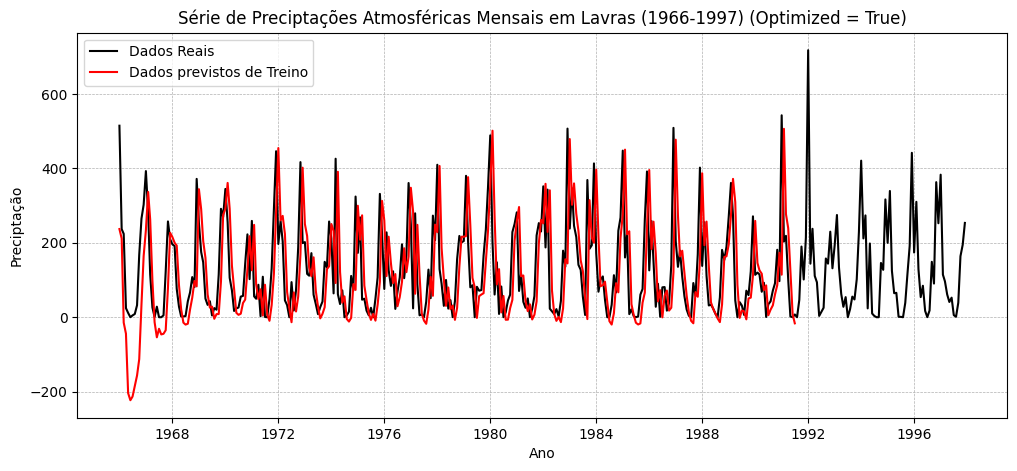

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')
plt.plot(SEH_opt.fittedvalues, color='red', label='Dados previstos de Treino')
plt.legend()

plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997) (Optimized = True)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

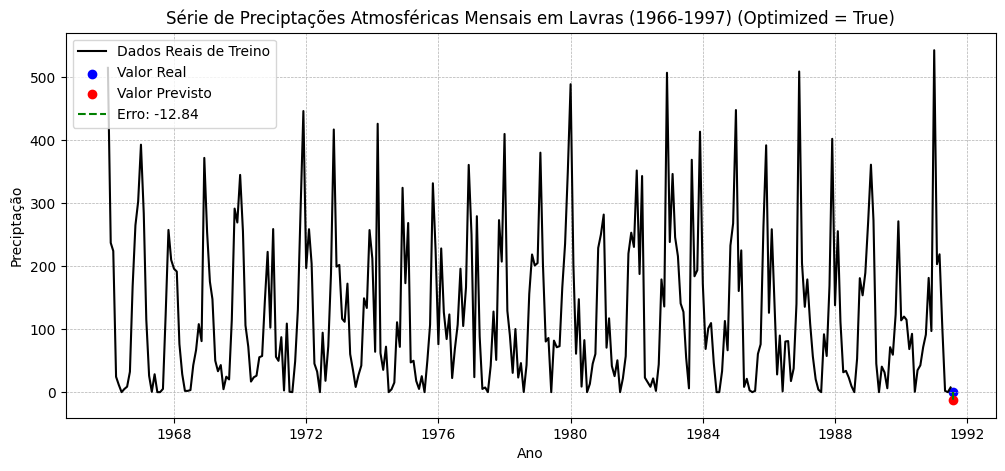

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SEH_opt.forecast(1), color='red', marker='o', label='Valor Previsto')

x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SEH_opt.forecast(1).values[0]]
erro = ((SEH_opt.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.legend()
plt.title('Série de Preciptações Atmosféricas Mensais em Lavras (1966-1997) (Optimized = True)')
plt.xlabel('Ano')
plt.ylabel('Preciptação')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SEH_opt.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SEH_opt.fittedvalues)**(1/2)}')

MSE TREINO: 15983.499323360653
RMSE TREINO: 126.4258649302454


In [ ]:
print('RMSE', ((SEH_opt.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2))

RMSE -12.835397337926791


In [ ]:
SEH_final = Holt(data2).fit(optimized=True)

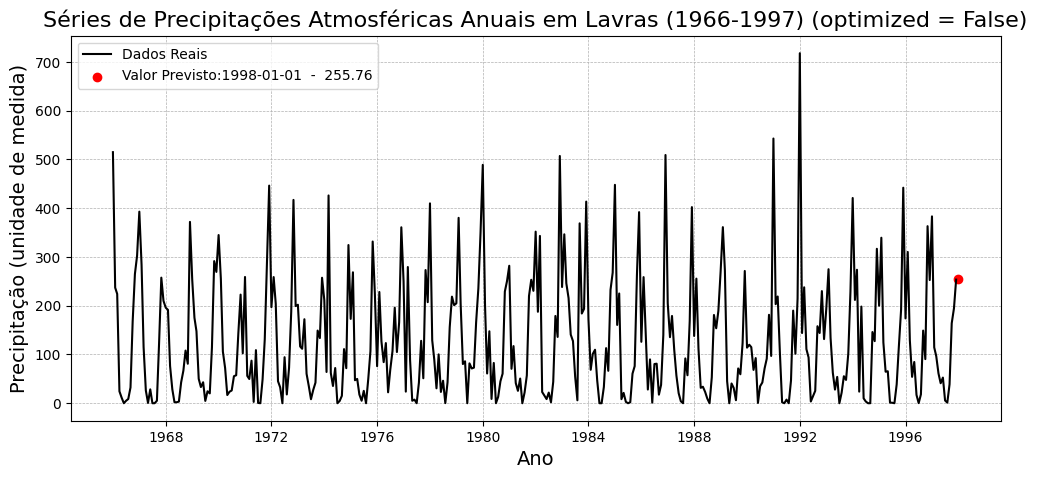

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')

plt.scatter(forecast_index, SEH_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997) (optimized = False)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h2> Suavização Exponencial de Holt-Winter</h2>

In [ ]:
has_zero = (data2 == 0).any().any()
has_zero

True

In [ ]:
epsilon = 1e-9
data2_corrigido = data2 + epsilon

In [ ]:
threshold = int(0.8*len(data2_corrigido))
train_set = data2_corrigido[:threshold]
test_set = data2_corrigido[threshold:]

In [ ]:
# sesonal periods precisa começar com pelo menos 2
#como estamos fazendo treino-teste, o valor máximo de seasonal periods é 59
season = 2
menor_mse = float('inf')
melhor_sp = 0
trend = ['add','mul']
seasonal = ['add','mul']
melhor_trend = ''
melhor_seasonal = ''
for t in trend:
    print(t)
    for s in seasonal:
        print(s)
        for i in range(2,40):
            SE = ExponentialSmoothing(train_set, seasonal_periods=i, trend=t, seasonal=s).fit()
            MSE_Treino = ((SE.resid)**2).mean()
            if MSE_Treino < menor_mse:
                menor_mse = MSE_Treino
                melhor_sp = i
                melhor_trend = t
                melhor_seasonal = s

            MSE_Teste = mean_squared_error(test_set,SE.forecast(len(test_set)))
            print(f'SEASONAL PERIOD= {i} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SP = {round(melhor_sp,2)} MELHOR TREND = {melhor_trend} MELHOR SEASONAL = {melhor_seasonal}')


add
add
SEASONAL PERIOD= 2 MSE TREINO: 13725.89 MSE TESTE: 35672.36
SEASONAL PERIOD= 3 MSE TREINO: 13498.79 MSE TESTE: 35475.06
SEASONAL PERIOD= 4 MSE TREINO: 14473.01 MSE TESTE: 110679.51
SEASONAL PERIOD= 5 MSE TREINO: 14438.09 MSE TESTE: 95262.82
SEASONAL PERIOD= 6 MSE TREINO: 14055.99 MSE TESTE: 188080.13
SEASONAL PERIOD= 7 MSE TREINO: 14515.48 MSE TESTE: 123026.06
SEASONAL PERIOD= 8 MSE TREINO: 14725.49 MSE TESTE: 135835.17
SEASONAL PERIOD= 9 MSE TREINO: 13419.13 MSE TESTE: 44846.84
SEASONAL PERIOD= 10 MSE TREINO: 14247.21 MSE TESTE: 51354.57
SEASONAL PERIOD= 11 MSE TREINO: 13634.91 MSE TESTE: 39780.07
SEASONAL PERIOD= 12 MSE TREINO: 5957.13 MSE TESTE: 7417.71
SEASONAL PERIOD= 13 MSE TREINO: 13061.21 MSE TESTE: 40062.2
SEASONAL PERIOD= 14 MSE TREINO: 13816.74 MSE TESTE: 25276.58
SEASONAL PERIOD= 15 MSE TREINO: 13589.72 MSE TESTE: 26132.18
SEASONAL PERIOD= 16 MSE TREINO: 13602.93 MSE TESTE: 38153.5
SEASONAL PERIOD= 17 MSE TREINO: 14078.16 MSE TESTE: 40429.0
SEASONAL PERIOD= 18 MSE T

In [ ]:
SE_final = ExponentialSmoothing(train_set, seasonal_periods=melhor_sp, trend=melhor_trend, seasonal=melhor_seasonal).fit()

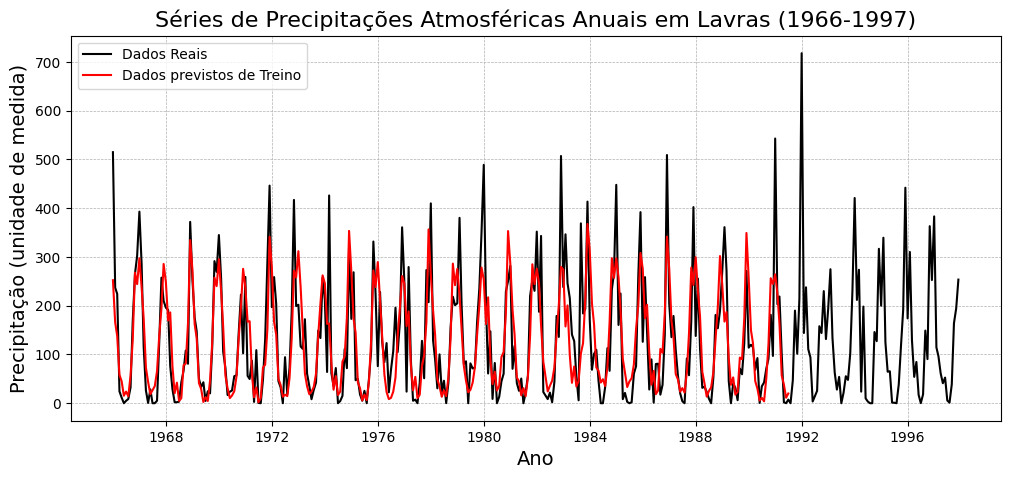

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data2_corrigido['Precipitação'], color='black', label='Dados Reais')
plt.plot(SE_final.fittedvalues, color='red', label='Dados previstos de Treino')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


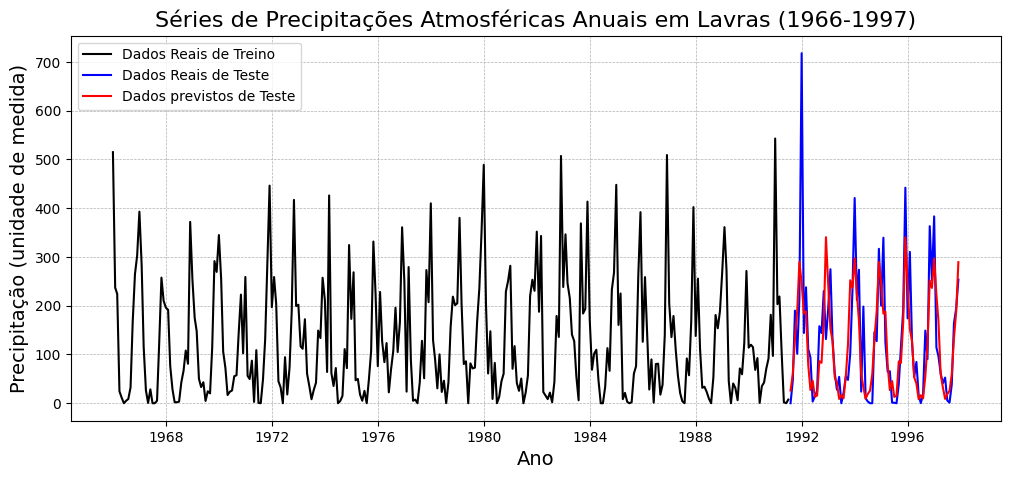

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.plot(test_set, color='blue', label='Dados Reais de Teste')
plt.plot(SE_final.forecast(len(test_set)), color='red', label='Dados previstos de Teste')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print(f'MSE TESTE: {mean_squared_error(test_set,SE_final.forecast(len(test_set)))}')
print(f'RMSE TESTE: {mean_squared_error(test_set,SE_final.forecast(len(test_set)))**(1/2)}')

MSE TESTE: 7181.939460652462
RMSE TESTE: 84.74632417192183


In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SE_final.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SE_final.fittedvalues)**(1/2)}')

MSE TREINO: 5429.905338842383
RMSE TREINO: 73.68789139907847


forecast para o futuro

In [ ]:
SE_final = ExponentialSmoothing(data2, seasonal_periods=melhor_sp, trend=melhor_trend, seasonal=melhor_seasonal).fit()

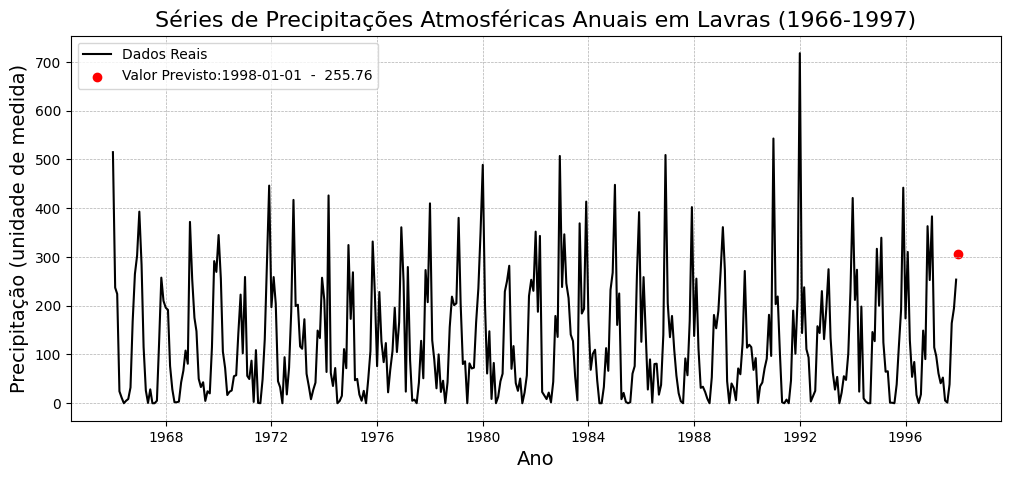

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')

plt.scatter(forecast_index, SE_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h4> <b> Podemos concluir que suavização exponencial de Holt-Winter performa bem nesta série devido a alta capacidade preditiva e fitting adequado</b></h4>

<h2> Árvore de decisão</h2>

In [ ]:
#vamos manter os valores de profundidade da arvore e valores de shift relativamente baixos para evitar overfitting
menor_mse = float('inf')
melhor_p = 0
melhor_depth = 0
for p in range(1,31):
    print('VALOR P ', p)
    data2_tree = data2.copy()
    for i in range(p):
        data2_tree[f'X_{i+1}'] = data2_tree['Precipitação'].shift(i+1)
    data2_tree.dropna(axis=0, inplace=True)
    x = data2_tree.drop('Precipitação', axis=1)
    y = data2_tree['Precipitação']
    for depth in range(1,6):
        print('VALOR DEPTH ', depth)
        model = DecisionTreeRegressor(max_depth=depth) # Com poda (prune)
        threshold = int(0.8*len(data2_tree))
        x_train = x[:threshold]
        x_test = x[threshold:]
        y_train = y[:threshold]
        y_test = y[threshold:]
        model.fit(x_train,y_train)
        MSE_Treino = mean_squared_error(y_train,model.predict(x_train))
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_p = p
            melhor_depth = depth
        MSE_Teste = mean_squared_error(model.predict(x_test),y_test.values)
        print(f'P = {p} DEPTJ = {depth} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR P = {melhor_p} MELHOR PROFUNDIDADE = {melhor_depth}')

VALOR P  1
VALOR DEPTH  1
P = 1 DEPTJ = 1 MSE TREINO: 10163.41 MSE TESTE: 12447.77
VALOR DEPTH  2
P = 1 DEPTJ = 2 MSE TREINO: 9062.38 MSE TESTE: 13434.5
VALOR DEPTH  3
P = 1 DEPTJ = 3 MSE TREINO: 8564.28 MSE TESTE: 13169.58
VALOR DEPTH  4
P = 1 DEPTJ = 4 MSE TREINO: 8139.44 MSE TESTE: 13178.0
VALOR DEPTH  5
P = 1 DEPTJ = 5 MSE TREINO: 7336.08 MSE TESTE: 15761.03
VALOR P  2
VALOR DEPTH  1
P = 2 DEPTJ = 1 MSE TREINO: 10193.1 MSE TESTE: 12449.58
VALOR DEPTH  2
P = 2 DEPTJ = 2 MSE TREINO: 9086.74 MSE TESTE: 13440.25
VALOR DEPTH  3
P = 2 DEPTJ = 3 MSE TREINO: 8588.46 MSE TESTE: 13174.38
VALOR DEPTH  4
P = 2 DEPTJ = 4 MSE TREINO: 8048.97 MSE TESTE: 14020.78
VALOR DEPTH  5
P = 2 DEPTJ = 5 MSE TREINO: 7293.87 MSE TESTE: 15825.77
VALOR P  3
VALOR DEPTH  1
P = 3 DEPTJ = 1 MSE TREINO: 10225.23 MSE TESTE: 12450.75
VALOR DEPTH  2
P = 3 DEPTJ = 2 MSE TREINO: 8752.28 MSE TESTE: 11629.87
VALOR DEPTH  3
P = 3 DEPTJ = 3 MSE TREINO: 7941.96 MSE TESTE: 12059.82
VALOR DEPTH  4
P = 3 DEPTJ = 4 MSE TREINO: 6

P = 3 DEPTJ = 5 MSE TREINO: 5482.56 MSE TESTE: 10742.01
VALOR P  4
VALOR DEPTH  1
P = 4 DEPTJ = 1 MSE TREINO: 10138.35 MSE TESTE: 12527.52
VALOR DEPTH  2
P = 4 DEPTJ = 2 MSE TREINO: 8316.53 MSE TESTE: 11160.49
VALOR DEPTH  3
P = 4 DEPTJ = 3 MSE TREINO: 7223.7 MSE TESTE: 10704.9
VALOR DEPTH  4
P = 4 DEPTJ = 4 MSE TREINO: 6084.52 MSE TESTE: 9792.14
VALOR DEPTH  5
P = 4 DEPTJ = 5 MSE TREINO: 4810.56 MSE TESTE: 9654.59
VALOR P  5
VALOR DEPTH  1
P = 5 DEPTJ = 1 MSE TREINO: 10157.66 MSE TESTE: 12526.56
VALOR DEPTH  2
P = 5 DEPTJ = 2 MSE TREINO: 7947.25 MSE TESTE: 10082.83
VALOR DEPTH  3
P = 5 DEPTJ = 3 MSE TREINO: 6668.9 MSE TESTE: 8944.09
VALOR DEPTH  4
P = 5 DEPTJ = 4 MSE TREINO: 4956.31 MSE TESTE: 9292.01
VALOR DEPTH  5
P = 5 DEPTJ = 5 MSE TREINO: 3968.62 MSE TESTE: 9121.84
VALOR P  6
VALOR DEPTH  1
P = 6 DEPTJ = 1 MSE TREINO: 9182.18 MSE TESTE: 11138.47
VALOR DEPTH  2
P = 6 DEPTJ = 2 MSE TREINO: 7236.49 MSE TESTE: 11506.65
VALOR DEPTH  3
P = 6 DEPTJ = 3 MSE TREINO: 5969.16 MSE TESTE: 101

In [ ]:
data2_tree = data2.copy()
p = melhor_p
for i in range(p):
  data2_tree[f'X_{i+1}'] = data2_tree['Precipitação'].shift(i+1)
data2_tree.dropna(axis=0, inplace=True)
x = data2_tree.drop('Precipitação', axis=1)
y = data2_tree['Precipitação']
threshold = int(0.8*len(data2_tree))
x_train = x[:threshold]
x_test = x[threshold:]
y_train = y[:threshold]
y_test = y[threshold:]

In [ ]:
tree_final = DecisionTreeRegressor(max_depth=melhor_depth)
tree_final.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5)

In [ ]:
y_train

Mes/ano
1968-05-01      2.0
1968-06-01      2.0
1968-07-01      3.3
1968-08-01     42.8
1968-09-01     66.8
              ...  
1991-08-01      0.0
1991-09-01     46.6
1991-10-01    190.0
1991-11-01    101.5
1991-12-01    214.9
Name: Precipitação, Length: 284, dtype: float64

In [ ]:
fitted = tree_final.predict(x_train)
fitted

array([ 36.11880342,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  72.55454545, 159.1       , 400.35555556,
       231.15      , 190.812     , 190.125     ,  36.11880342,
        36.11880342,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  36.11880342, 270.24285714, 231.15      ,
       231.15      , 190.812     ,  89.35625   ,  89.35625   ,
        36.11880342,  36.11880342,  36.11880342,  36.11880342,
        36.11880342, 160.93125   , 160.93125   , 159.1       ,
       190.812     , 105.2       ,  88.21538462,  88.21538462,
        36.11880342,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  89.35625   , 270.24285714, 270.24285714,
       231.15      , 190.812     , 153.36      ,  89.35625   ,
        36.11880342,  36.11880342,  36.11880342,  36.11880342,
        36.11880342, 160.93125   , 400.35555556, 239.3       ,
       190.812     , 160.93125   , 105.2       ,  88.21538462,
        36.11880342,  36.11880342,  36.11880342,  36.11

In [ ]:
dates = pd.date_range(start=y_train.index[0], periods=len(fitted), freq='MS')
fitted_dates = pd.Series(fitted, index=dates, name='Valores')
fitted_dates

1968-05-01     36.118803
1968-06-01     36.118803
1968-07-01     36.118803
1968-08-01     36.118803
1968-09-01     36.118803
                 ...    
1991-08-01     36.118803
1991-09-01     36.118803
1991-10-01    190.000000
1991-11-01     36.118803
1991-12-01    270.242857
Freq: MS, Name: Valores, Length: 284, dtype: float64

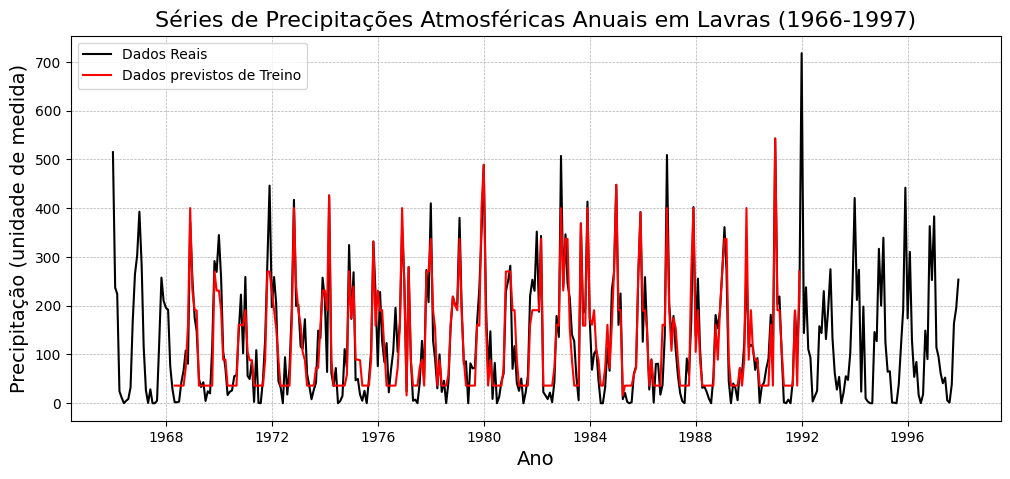

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')
plt.plot(fitted_dates, color='red', label='Dados previstos de Treino')
plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
forecast= tree_final.predict(x_test)
forecast

array([190.125     ,  89.35625   , 153.36      , 153.36      ,
        36.11880342,  36.11880342,  36.11880342,  36.11880342,
       160.93125   ,  36.11880342, 160.93125   , 160.93125   ,
       190.812     , 190.812     , 190.812     ,  36.11880342,
        88.21538462,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  72.55454545,  36.11880342, 270.24285714,
       448.        , 105.2       , 190.812     ,  88.21538462,
       153.36      ,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  36.11880342, 159.1       , 160.93125   ,
       190.812     , 190.812     , 337.14285714, 153.36      ,
        88.21538462,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  36.11880342, 160.93125   , 400.35555556,
       270.24285714, 231.15      , 190.812     , 337.14285714,
        16.05      ,  36.11880342,  36.11880342,  36.11880342,
        36.11880342,  72.55454545,  72.55454545, 270.24285714,
       270.24285714, 190.812     , 337.14285714,  88.21

In [ ]:
dates = pd.date_range(start=y_test.index[0], periods=len(forecast), freq='MS')
forecast_dates = pd.Series(forecast, index=dates, name='Valores')
forecast_dates

1992-01-01    190.125000
1992-02-01     89.356250
1992-03-01    153.360000
1992-04-01    153.360000
1992-05-01     36.118803
                 ...    
1997-08-01     36.118803
1997-09-01     36.118803
1997-10-01     72.554545
1997-11-01    159.100000
1997-12-01    270.242857
Freq: MS, Name: Valores, Length: 72, dtype: float64

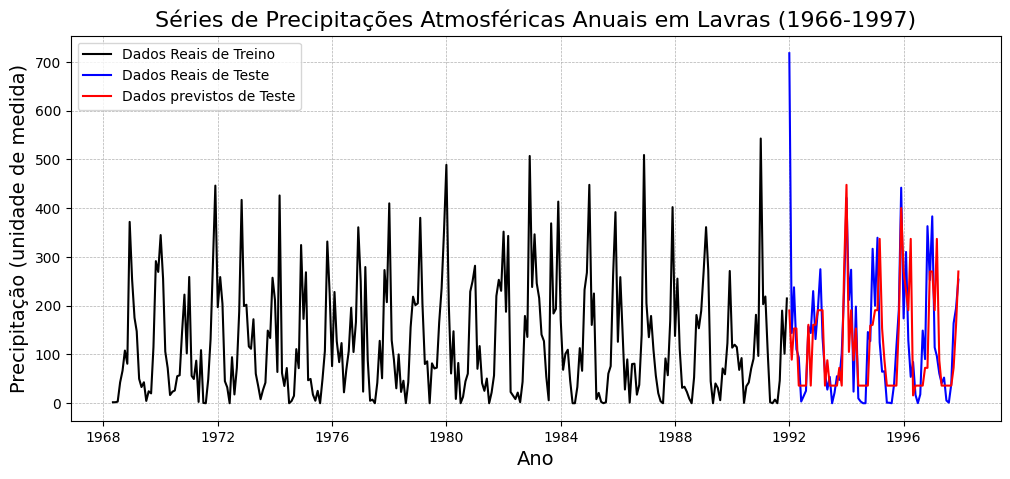

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_train, color='black', label='Dados Reais de Treino')
plt.plot(y_test, color='blue', label='Dados Reais de Teste')
plt.plot(forecast_dates, color='red', label='Dados previstos de Teste')
plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print("MSE TREINO",mean_squared_error(y_train,fitted_dates))
print("RMSE TREINO",mean_squared_error(y_train,fitted_dates)**(1/2))

MSE TREINO 2061.3444435296124
RMSE TREINO 45.402031270964216


In [ ]:
print("MSE TESTE",mean_squared_error(y_test,forecast_dates))
print("RMSE TESTE",mean_squared_error(y_test,forecast_dates)**(1/2))

MSE TESTE 10907.483119555198
RMSE TESTE 104.43889658338601


forecast para o futuro

In [ ]:
tree_final = DecisionTreeRegressor(max_depth=melhor_depth)
tree_final.fit(data2_tree.drop('Precipitação', axis=1),data2_tree['Precipitação'])

DecisionTreeRegressor(max_depth=5)

ValueError: x and y must be the same size

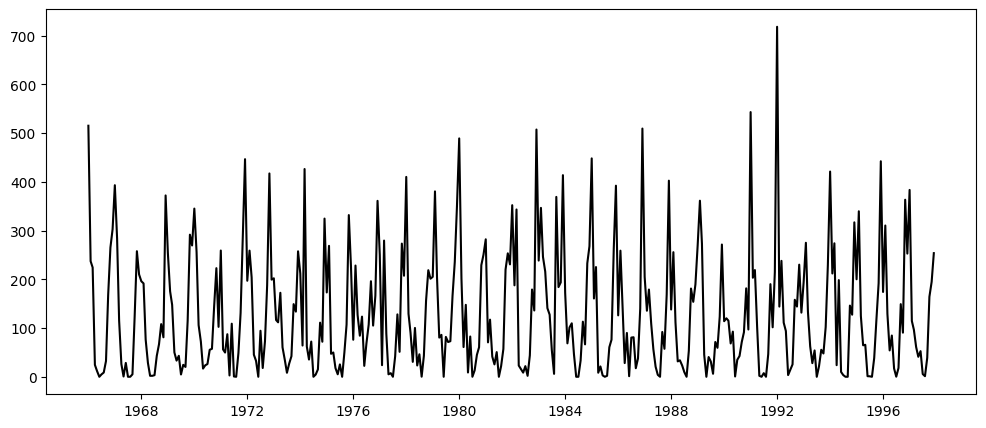

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data2['Precipitação'], color='black', label='Dados Reais')

plt.scatter(forecast_index, tree_final.predict, color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h2> Prophet </h2>

In [ ]:
data2_prop

,ds,y
0,1966-01-01,515.0
1,1966-02-01,237.1
2,1966-03-01,224.2
3,1966-04-01,24.4
4,1966-05-01,11.6
...,...,...
379,1997-08-01,1.2
380,1997-09-01,38.8
381,1997-10-01,164.1
382,1997-11-01,194.8


In [ ]:
data2_prop = pd.read_excel('https://www.ime.usp.br/~pam/LAVRAS.XLS')
data2_prop['Mes/ano'] = main.time_data2()

In [ ]:
# por especificação do algoritmo:
# precisamos deixar as datas em uma coluna 'ds' e os valores da serie em uma coluna 'y'"AST_Aula_9_Modelo_SARIMA_20041208 (1).ipynb"
data2_prop = data2_prop.rename(columns={'Mes/ano': 'ds'})
data2_prop = data2_prop.rename(columns={'Precipitação': 'y'})

In [ ]:
# treino -teste
train_size = int(len(data2_prop) * 0.8)  # 80% of the data for training, adjust the split ratio as needed
train = data2_prop[:train_size]
test = data2_prop[train_size:]

In [ ]:
change=0.1
menor_mse = float('inf')
melhor_change = 0
melhor_seasonal_scale = 0
for season_scale in range(1,21):
    change=0.1
    while True:
        if change>1:
            break
        model = Prophet(
        growth='linear',                   # Define o crescimento como linear
        changepoint_prior_scale=change,       # Ajusta a sensibilidade aos pontos de mudança na série temporal
        seasonality_prior_scale=season_scale,        # Escala do prior para a sazonalidade
        seasonality_mode='multiplicative', # Utiliza a sazonalidade multiplicativa para se adaptar a mudanças
        yearly_seasonality=True,           # Mantém a sazonalidade anual
        weekly_seasonality=False,          # Sem sazonalidade semanal (se não aplicável)
        daily_seasonality=False            # Sem sazonalidade diária (se não aplicável)
        )

        # Ajusta o modelo aos dados (substitua 'data2' pelo seu DataFrame)
        model.fit(train)
        fitted = model.predict(train)
        MSE_Treino = mean_squared_error(train['y'], fitted['yhat'])
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_change = change
            melhor_seasonal_scale = season_scale
        print(f'MSE TREINO {MSE_Treino} CHANGE = {change} SEASONAL SCALE {season_scale}')
        change+=0.1
        change = round(change,2)

print(f'MENOR MSE TREINO = {menor_mse} MELHOR CHANGE = {melhor_change} MELHOR SEASONAL SCALE = {melhor_seasonal_scale}')



23:31:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5353.795576273548 CHANGE = 0.1 SEASONAL SCALE 1


23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5216.234094623617 CHANGE = 0.2 SEASONAL SCALE 1


23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5153.920882684344 CHANGE = 0.3 SEASONAL SCALE 1


23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5121.451276125663 CHANGE = 0.4 SEASONAL SCALE 1


23:32:02 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5115.4311086289035 CHANGE = 0.5 SEASONAL SCALE 1


23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5088.945306577699 CHANGE = 0.6 SEASONAL SCALE 1


23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5088.228038934521 CHANGE = 0.7 SEASONAL SCALE 1


23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5072.747489329068 CHANGE = 0.8 SEASONAL SCALE 1


23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5059.192076896776 CHANGE = 0.9 SEASONAL SCALE 1


23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5036.418757140931 CHANGE = 1.0 SEASONAL SCALE 1


23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5342.088180123123 CHANGE = 0.1 SEASONAL SCALE 2


23:32:06 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5212.5788214725535 CHANGE = 0.2 SEASONAL SCALE 2


23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5106.717540572734 CHANGE = 0.3 SEASONAL SCALE 2


23:32:08 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5079.32997532483 CHANGE = 0.4 SEASONAL SCALE 2


23:32:08 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5046.008254666523 CHANGE = 0.5 SEASONAL SCALE 2


23:32:09 - cmdstanpy - INFO - Chain [1] start processing
23:32:09 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5035.4056184539595 CHANGE = 0.6 SEASONAL SCALE 2


23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5021.426117705905 CHANGE = 0.7 SEASONAL SCALE 2


23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5025.041588474408 CHANGE = 0.8 SEASONAL SCALE 2


23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5015.9922216877685 CHANGE = 0.9 SEASONAL SCALE 2


23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4992.786085380848 CHANGE = 1.0 SEASONAL SCALE 2


23:32:12 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5358.441965012938 CHANGE = 0.1 SEASONAL SCALE 3


23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5188.166095252392 CHANGE = 0.2 SEASONAL SCALE 3


23:32:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5120.04579198914 CHANGE = 0.3 SEASONAL SCALE 3


23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5046.546391949227 CHANGE = 0.4 SEASONAL SCALE 3


23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5041.629319641469 CHANGE = 0.5 SEASONAL SCALE 3


23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5035.398403017327 CHANGE = 0.6 SEASONAL SCALE 3


23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5034.825193609544 CHANGE = 0.7 SEASONAL SCALE 3


23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:15 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5009.54686235521 CHANGE = 0.8 SEASONAL SCALE 3


23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:15 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5000.682017292832 CHANGE = 0.9 SEASONAL SCALE 3


23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4994.863555083106 CHANGE = 1.0 SEASONAL SCALE 3


23:32:16 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5350.984998642154 CHANGE = 0.1 SEASONAL SCALE 4


23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5208.129770825893 CHANGE = 0.2 SEASONAL SCALE 4


23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5115.12575874904 CHANGE = 0.3 SEASONAL SCALE 4


23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5066.642622404159 CHANGE = 0.4 SEASONAL SCALE 4


23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5027.750414931218 CHANGE = 0.5 SEASONAL SCALE 4


23:32:18 - cmdstanpy - INFO - Chain [1] done processing
23:32:18 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5021.358185895703 CHANGE = 0.6 SEASONAL SCALE 4


23:32:18 - cmdstanpy - INFO - Chain [1] done processing
23:32:18 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5020.867810182578 CHANGE = 0.7 SEASONAL SCALE 4


23:32:18 - cmdstanpy - INFO - Chain [1] done processing
23:32:19 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5000.156130339354 CHANGE = 0.8 SEASONAL SCALE 4


23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4992.945819589462 CHANGE = 0.9 SEASONAL SCALE 4


23:32:19 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4988.597221991957 CHANGE = 1.0 SEASONAL SCALE 4


23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5344.268915661329 CHANGE = 0.1 SEASONAL SCALE 5


23:32:20 - cmdstanpy - INFO - Chain [1] done processing
23:32:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5206.649793447527 CHANGE = 0.2 SEASONAL SCALE 5


23:32:20 - cmdstanpy - INFO - Chain [1] done processing
23:32:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5067.0595576616815 CHANGE = 0.3 SEASONAL SCALE 5


23:32:20 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5076.599509991829 CHANGE = 0.4 SEASONAL SCALE 5


23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5048.419077193869 CHANGE = 0.5 SEASONAL SCALE 5


23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5027.357968386211 CHANGE = 0.6 SEASONAL SCALE 5


23:32:22 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5020.148122625899 CHANGE = 0.7 SEASONAL SCALE 5


23:32:22 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5009.98519097101 CHANGE = 0.8 SEASONAL SCALE 5


23:32:22 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4990.003383912669 CHANGE = 0.9 SEASONAL SCALE 5


23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4988.560372134131 CHANGE = 1.0 SEASONAL SCALE 5


23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5341.661992644619 CHANGE = 0.1 SEASONAL SCALE 6


23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5152.071118234527 CHANGE = 0.2 SEASONAL SCALE 6


23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5087.331614888248 CHANGE = 0.3 SEASONAL SCALE 6


23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5044.881392531464 CHANGE = 0.4 SEASONAL SCALE 6


23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:25 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5039.575971371538 CHANGE = 0.5 SEASONAL SCALE 6


23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:25 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5015.038534312632 CHANGE = 0.6 SEASONAL SCALE 6


23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5023.477903329313 CHANGE = 0.7 SEASONAL SCALE 6


23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4995.734845590708 CHANGE = 0.8 SEASONAL SCALE 6


23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4988.134319487956 CHANGE = 0.9 SEASONAL SCALE 6


23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4980.615017923936 CHANGE = 1.0 SEASONAL SCALE 6


23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5338.941863526705 CHANGE = 0.1 SEASONAL SCALE 7


23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5188.886368426944 CHANGE = 0.2 SEASONAL SCALE 7


23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5098.919559872045 CHANGE = 0.3 SEASONAL SCALE 7


23:32:28 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5047.85856084308 CHANGE = 0.4 SEASONAL SCALE 7


23:32:28 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5035.687022488773 CHANGE = 0.5 SEASONAL SCALE 7


23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5013.70645384173 CHANGE = 0.6 SEASONAL SCALE 7


23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5021.666990874992 CHANGE = 0.7 SEASONAL SCALE 7


23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5002.049572465012 CHANGE = 0.8 SEASONAL SCALE 7


23:32:30 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4999.0442686381675 CHANGE = 0.9 SEASONAL SCALE 7


23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:30 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4981.438143302802 CHANGE = 1.0 SEASONAL SCALE 7


23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5360.320837018098 CHANGE = 0.1 SEASONAL SCALE 8


23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:32 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5154.839531292512 CHANGE = 0.2 SEASONAL SCALE 8


23:32:32 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5070.519821672966 CHANGE = 0.3 SEASONAL SCALE 8


23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5060.802001354972 CHANGE = 0.4 SEASONAL SCALE 8


23:32:33 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5032.0682352008225 CHANGE = 0.5 SEASONAL SCALE 8


23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5029.910357371505 CHANGE = 0.6 SEASONAL SCALE 8


23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing
23:32:35 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5018.047309524119 CHANGE = 0.7 SEASONAL SCALE 8


23:32:35 - cmdstanpy - INFO - Chain [1] done processing
23:32:35 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4993.884620892134 CHANGE = 0.8 SEASONAL SCALE 8


23:32:35 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4982.791714552409 CHANGE = 0.9 SEASONAL SCALE 8


23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4984.418495639972 CHANGE = 1.0 SEASONAL SCALE 8


23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing
23:32:36 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5347.425466563097 CHANGE = 0.1 SEASONAL SCALE 9


23:32:37 - cmdstanpy - INFO - Chain [1] done processing
23:32:37 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5177.276161275044 CHANGE = 0.2 SEASONAL SCALE 9


23:32:37 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5121.530589001562 CHANGE = 0.3 SEASONAL SCALE 9


23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5044.47419269191 CHANGE = 0.4 SEASONAL SCALE 9


23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5041.526516017441 CHANGE = 0.5 SEASONAL SCALE 9


23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5019.777683416548 CHANGE = 0.6 SEASONAL SCALE 9


23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:40 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5012.274190021529 CHANGE = 0.7 SEASONAL SCALE 9


23:32:40 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5007.785143062973 CHANGE = 0.8 SEASONAL SCALE 9


23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4987.728475119517 CHANGE = 0.9 SEASONAL SCALE 9


23:32:41 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4982.025840873955 CHANGE = 1.0 SEASONAL SCALE 9


23:32:41 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5351.405495053975 CHANGE = 0.1 SEASONAL SCALE 10


23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
23:32:42 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5173.291966046291 CHANGE = 0.2 SEASONAL SCALE 10


23:32:42 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5123.021620277547 CHANGE = 0.3 SEASONAL SCALE 10


23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5071.479954217506 CHANGE = 0.4 SEASONAL SCALE 10


23:32:43 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5029.763044373505 CHANGE = 0.5 SEASONAL SCALE 10


23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5016.504302257261 CHANGE = 0.6 SEASONAL SCALE 10


23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5015.904136677288 CHANGE = 0.7 SEASONAL SCALE 10


23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4996.410187355906 CHANGE = 0.8 SEASONAL SCALE 10


23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4995.8849922120835 CHANGE = 0.9 SEASONAL SCALE 10


23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4987.511374440412 CHANGE = 1.0 SEASONAL SCALE 10


23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5345.83832173455 CHANGE = 0.1 SEASONAL SCALE 11


23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5190.430677354551 CHANGE = 0.2 SEASONAL SCALE 11


23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5117.882010575605 CHANGE = 0.3 SEASONAL SCALE 11


23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5044.0937585283855 CHANGE = 0.4 SEASONAL SCALE 11


23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5025.424209872702 CHANGE = 0.5 SEASONAL SCALE 11


23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5015.139699019718 CHANGE = 0.6 SEASONAL SCALE 11


23:32:48 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5011.987658604835 CHANGE = 0.7 SEASONAL SCALE 11


23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5010.829477456309 CHANGE = 0.8 SEASONAL SCALE 11


23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4997.219870272273 CHANGE = 0.9 SEASONAL SCALE 11


23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4981.787540836322 CHANGE = 1.0 SEASONAL SCALE 11


23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5349.444812743266 CHANGE = 0.1 SEASONAL SCALE 12


23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5214.847117410548 CHANGE = 0.2 SEASONAL SCALE 12


23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5098.295986534978 CHANGE = 0.3 SEASONAL SCALE 12


23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5054.610874351847 CHANGE = 0.4 SEASONAL SCALE 12


23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5039.610971172081 CHANGE = 0.5 SEASONAL SCALE 12


23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5028.918928898189 CHANGE = 0.6 SEASONAL SCALE 12


23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5017.18787166453 CHANGE = 0.7 SEASONAL SCALE 12


23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4992.175585466124 CHANGE = 0.8 SEASONAL SCALE 12


23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4987.891364594936 CHANGE = 0.9 SEASONAL SCALE 12


23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4981.278885423998 CHANGE = 1.0 SEASONAL SCALE 12


23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5349.122146702526 CHANGE = 0.1 SEASONAL SCALE 13


23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5182.457021439688 CHANGE = 0.2 SEASONAL SCALE 13


23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5092.190870470128 CHANGE = 0.3 SEASONAL SCALE 13


23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5046.6198094123665 CHANGE = 0.4 SEASONAL SCALE 13


23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5022.27301458102 CHANGE = 0.5 SEASONAL SCALE 13


23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5032.246357240212 CHANGE = 0.6 SEASONAL SCALE 13


23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5011.876404583067 CHANGE = 0.7 SEASONAL SCALE 13


23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5005.297447290956 CHANGE = 0.8 SEASONAL SCALE 13


23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4994.480703263879 CHANGE = 0.9 SEASONAL SCALE 13


23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4985.981571277829 CHANGE = 1.0 SEASONAL SCALE 13


23:32:59 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5353.564694775411 CHANGE = 0.1 SEASONAL SCALE 14


23:32:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing
23:32:59 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5211.843344939805 CHANGE = 0.2 SEASONAL SCALE 14


23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5101.968206404193 CHANGE = 0.3 SEASONAL SCALE 14


23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5062.884554889146 CHANGE = 0.4 SEASONAL SCALE 14


23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:01 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5039.82807135868 CHANGE = 0.5 SEASONAL SCALE 14


23:33:01 - cmdstanpy - INFO - Chain [1] done processing
23:33:01 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5014.966588893903 CHANGE = 0.6 SEASONAL SCALE 14


23:33:01 - cmdstanpy - INFO - Chain [1] done processing
23:33:01 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5016.707092216357 CHANGE = 0.7 SEASONAL SCALE 14


23:33:02 - cmdstanpy - INFO - Chain [1] done processing
23:33:02 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5005.1990628265385 CHANGE = 0.8 SEASONAL SCALE 14


23:33:02 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4992.556374853167 CHANGE = 0.9 SEASONAL SCALE 14


23:33:02 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4989.180317623607 CHANGE = 1.0 SEASONAL SCALE 14


23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing
23:33:03 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5345.147205506467 CHANGE = 0.1 SEASONAL SCALE 15


23:33:03 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5210.154389496659 CHANGE = 0.2 SEASONAL SCALE 15


23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5120.834830416962 CHANGE = 0.3 SEASONAL SCALE 15


23:33:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5044.1672155055985 CHANGE = 0.4 SEASONAL SCALE 15


23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing
23:33:05 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5051.4272025459995 CHANGE = 0.5 SEASONAL SCALE 15


23:33:06 - cmdstanpy - INFO - Chain [1] done processing
23:33:06 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5027.987651144067 CHANGE = 0.6 SEASONAL SCALE 15


23:33:06 - cmdstanpy - INFO - Chain [1] done processing
23:33:06 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5011.835316467126 CHANGE = 0.7 SEASONAL SCALE 15


23:33:07 - cmdstanpy - INFO - Chain [1] done processing
23:33:07 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5003.7471472162015 CHANGE = 0.8 SEASONAL SCALE 15


23:33:07 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4992.464562947349 CHANGE = 0.9 SEASONAL SCALE 15


23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:08 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4981.920869284498 CHANGE = 1.0 SEASONAL SCALE 15


23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:08 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5351.167472569954 CHANGE = 0.1 SEASONAL SCALE 16


23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5209.435717955608 CHANGE = 0.2 SEASONAL SCALE 16


23:33:09 - cmdstanpy - INFO - Chain [1] done processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5127.271726089574 CHANGE = 0.3 SEASONAL SCALE 16


23:33:09 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5043.763512067622 CHANGE = 0.4 SEASONAL SCALE 16


23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5043.034505941799 CHANGE = 0.5 SEASONAL SCALE 16


23:33:10 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5014.683606742467 CHANGE = 0.6 SEASONAL SCALE 16


23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5019.595271705448 CHANGE = 0.7 SEASONAL SCALE 16


23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4997.271319433609 CHANGE = 0.8 SEASONAL SCALE 16


23:33:12 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4991.891436738001 CHANGE = 0.9 SEASONAL SCALE 16


23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4979.334332982157 CHANGE = 1.0 SEASONAL SCALE 16


23:33:13 - cmdstanpy - INFO - Chain [1] done processing
23:33:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5351.260266015581 CHANGE = 0.1 SEASONAL SCALE 17


23:33:13 - cmdstanpy - INFO - Chain [1] done processing
23:33:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5150.137980177313 CHANGE = 0.2 SEASONAL SCALE 17


23:33:14 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5082.28343067384 CHANGE = 0.3 SEASONAL SCALE 17


23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing
23:33:15 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5035.829126601029 CHANGE = 0.4 SEASONAL SCALE 17


23:33:15 - cmdstanpy - INFO - Chain [1] done processing
23:33:15 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5058.767301936725 CHANGE = 0.5 SEASONAL SCALE 17


23:33:15 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5016.014857798488 CHANGE = 0.6 SEASONAL SCALE 17


23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:16 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5018.52172800334 CHANGE = 0.7 SEASONAL SCALE 17


23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5004.954607844016 CHANGE = 0.8 SEASONAL SCALE 17


23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4988.452142845108 CHANGE = 0.9 SEASONAL SCALE 17


23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4986.240444033865 CHANGE = 1.0 SEASONAL SCALE 17


23:33:18 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5345.770266345333 CHANGE = 0.1 SEASONAL SCALE 18


23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:19 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5179.522084984461 CHANGE = 0.2 SEASONAL SCALE 18


23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:19 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5108.627723443174 CHANGE = 0.3 SEASONAL SCALE 18


23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5062.029299800368 CHANGE = 0.4 SEASONAL SCALE 18


23:33:20 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5034.793324724701 CHANGE = 0.5 SEASONAL SCALE 18


23:33:20 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5027.715395207547 CHANGE = 0.6 SEASONAL SCALE 18


23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5019.313384145505 CHANGE = 0.7 SEASONAL SCALE 18


23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5003.193284981341 CHANGE = 0.8 SEASONAL SCALE 18


23:33:22 - cmdstanpy - INFO - Chain [1] done processing
23:33:22 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4986.634838463934 CHANGE = 0.9 SEASONAL SCALE 18


23:33:22 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4985.49865284337 CHANGE = 1.0 SEASONAL SCALE 18


23:33:23 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5353.299015903284 CHANGE = 0.1 SEASONAL SCALE 19


23:33:24 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 5168.892207187585 CHANGE = 0.2 SEASONAL SCALE 19


23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5084.593335669301 CHANGE = 0.3 SEASONAL SCALE 19


23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:26 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5056.547213296992 CHANGE = 0.4 SEASONAL SCALE 19


23:33:26 - cmdstanpy - INFO - Chain [1] done processing
23:33:26 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5023.277795117241 CHANGE = 0.5 SEASONAL SCALE 19


23:33:26 - cmdstanpy - INFO - Chain [1] done processing
23:33:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5017.310814246506 CHANGE = 0.6 SEASONAL SCALE 19


23:33:27 - cmdstanpy - INFO - Chain [1] done processing
23:33:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5003.181914980292 CHANGE = 0.7 SEASONAL SCALE 19


23:33:27 - cmdstanpy - INFO - Chain [1] done processing
23:33:27 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4993.439606535726 CHANGE = 0.8 SEASONAL SCALE 19


23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:28 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4988.443554370009 CHANGE = 0.9 SEASONAL SCALE 19


23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:28 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4986.203630655901 CHANGE = 1.0 SEASONAL SCALE 19


23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:29 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5348.681345110364 CHANGE = 0.1 SEASONAL SCALE 20


23:33:29 - cmdstanpy - INFO - Chain [1] done processing
23:33:29 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5182.950818282403 CHANGE = 0.2 SEASONAL SCALE 20


23:33:29 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5111.977927700479 CHANGE = 0.3 SEASONAL SCALE 20


23:33:30 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5047.9223869684765 CHANGE = 0.4 SEASONAL SCALE 20


23:33:30 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5019.15665014376 CHANGE = 0.5 SEASONAL SCALE 20


23:33:30 - cmdstanpy - INFO - Chain [1] done processing
23:33:31 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5030.773879035912 CHANGE = 0.6 SEASONAL SCALE 20


23:33:31 - cmdstanpy - INFO - Chain [1] done processing
23:33:31 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5002.222873762151 CHANGE = 0.7 SEASONAL SCALE 20


23:33:31 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 5004.673952810901 CHANGE = 0.8 SEASONAL SCALE 20


23:33:32 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 4993.365892031383 CHANGE = 0.9 SEASONAL SCALE 20


23:33:32 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 4981.548953477369 CHANGE = 1.0 SEASONAL SCALE 20
MENOR MSE TREINO = 4979.334332982157 MELHOR CHANGE = 1.0 MELHOR SEASONAL SCALE = 16


In [ ]:
# Inicialização do modelo Prophet

model = Prophet(
    growth='linear',                   # Define o crescimento como linear
    changepoint_prior_scale=melhor_change,       # Ajusta a sensibilidade aos pontos de mudança na série temporal
    seasonality_prior_scale=melhor_seasonal_scale,        # Escala do prior para a sazonalidade
    seasonality_mode='multiplicative', # Utiliza a sazonalidade multiplicativa para se adaptar a mudanças
    yearly_seasonality=True,           # Mantém a sazonalidade anual
    weekly_seasonality=False,          # Sem sazonalidade semanal (se não aplicável)
    daily_seasonality=False            # Sem sazonalidade diária (se não aplicável)
)

# Fitting
model.fit(train)

23:36:05 - cmdstanpy - INFO - Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
fitted = model.predict(train)

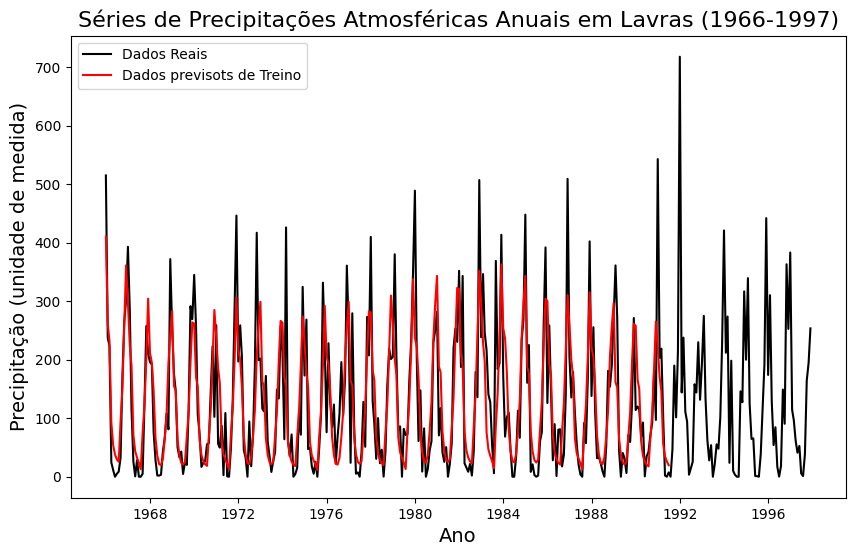

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the actual data
ax.plot(data2_prop['ds'], data2_prop['y'], label='Dados Reais', color='black')

# Plotting the fitted values
ax.plot(fitted['ds'], fitted['yhat'], label='Dados previsots de Treino', color='red')

# Adding labels and legend
plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
print('MSE TREINO', mean_squared_error(train['y'], fitted['yhat']))
print('RMSE TREINO', mean_squared_error(train['y'], fitted['yhat'])**(1/2))

MSE TREINO 4979.334332982157
RMSE TREINO 70.56439848097735


In [ ]:
forecast = model.predict(test)

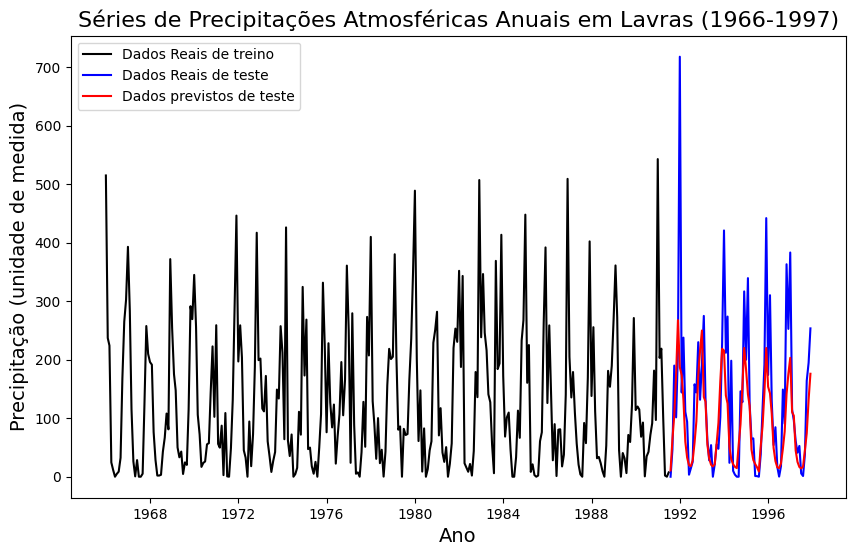

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['ds'], train['y'], label='Dados Reais de treino', color='black')
ax.plot(test['ds'], test['y'], label='Dados Reais de teste', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Dados previstos de teste', color='red')

# Adding labels and legend
plt.title('Séries de Precipitações Atmosféricas Anuais em Lavras (1966-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
print('MSE TESTE', mean_squared_error(test['y'], forecast['yhat']))
print('RMSE TESTE', mean_squared_error(test['y'], forecast['yhat'])**(1/2))


MSE TESTE 9482.435599878203
RMSE TESTE 97.37779829036084


<h4> Previsao</h4>    

In [ ]:
future = model.make_future_dataframe(periods=300,freq='M', include_history=True)
future

,ds
0,1966-01-01
1,1966-02-01
2,1966-03-01
3,1966-04-01
4,1966-05-01
...,...
602,2016-02-29
603,2016-03-31
604,2016-04-30
605,2016-05-31


In [ ]:
forecast_final = model.predict(future)
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
602,2016-02-29,-11.146043,-428.616244,358.528152
603,2016-03-31,-4.219151,-185.619527,169.316423
604,2016-04-30,-2.871177,-136.475501,130.831647
605,2016-05-31,-2.439149,-129.789198,118.251047
606,2016-06-30,-1.779341,-104.185764,97.388671


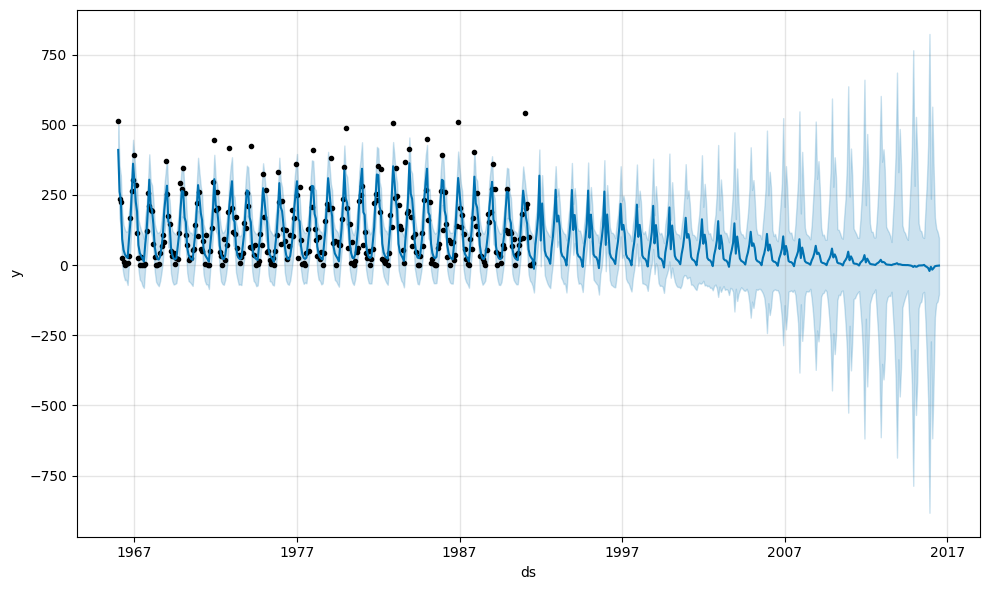

In [ ]:
fig1 = model.plot(forecast_final)